Pemetaan Posisi Kompetitif Coffee Shop di Kota Bogor Berdasarkan Persepsi Konsumen: Pendekatan Multi-Dimensional Scaling (MDS) dan Text Mining

# Pendahuluan
Industri kedai kopi (coffee shop) di Kota Bogor mengalami pertumbuhan eksponensial dalam beberapa tahun terakhir. Tidak lagi sekadar tempat menikmati kafein, kedai kopi telah bertransformasi menjadi "ruang ketiga" (third place) yang mengakomodasi gaya hidup modern, mulai dari aktivitas sosial (hangout) hingga kebutuhan produktivitas (Work From Cafe). Fenomena ini menciptakan pasar yang sangat jenuh (saturated market), di mana pembedaan merek berdasarkan harga semata tidak lagi cukup. Pelaku bisnis dan konsumen menghadapi kompleksitas dalam menentukan posisi tawar: mana kedai kopi yang menawarkan pengalaman rasa terbaik, dan mana yang sekadar menjual fasilitas kerja. Oleh karena itu, memetakan posisi kompetitif berdasarkan persepsi riil konsumen menjadi urgensi strategis untuk memahami lanskap persaingan yang sebenarnya.

Penelitian ini menggunakan pendekatan Data-Driven dengan mengambil objek studi pada 8 coffee shop terkemuka di Kota Bogor yang mewakili segmen High-End (Starbucks, Kopi Wangsa), Mid-Range (Rumaja, Tikkum), hingga Budget (Kopi Kenangan, Janji Jiwa, dan Tomoro). Data yang digunakan merupakan kombinasi data kuantitatif dan kualitatif. Variabel harga (Americano) dikumpulkan melalui observasi menu. Sementara itu, variabel persepsi (Skor Rasa, Skor Suasana, dan Skor WFC) didapatkan melalui teknik Web Scraping pada ratusan ulasan Google Maps terbaru.

Proses analisis dimulai dengan tahap preprocessing data teks ulasan menggunakan teknik Text Mining tingkat lanjut, meliputi normalisasi bahasa gaul (slang handling), stemming (Sastrawi), dan rule-based sentiment analysis untuk mengubah opini kualitatif menjadi skor kuantitatif (Skala 1-5). Data multivariat yang telah terstandarisasi kemudian diolah menggunakan metode statistika Multi-Dimensional Scaling (MDS). Metode ini mereduksi dimensi data kompleks menjadi Peta Persepsi (Perceptual Map) 2 dimensi, yang memungkinkan visualisasi jarak kemiripan antar brand serta identifikasi pola persaingan berdasarkan sumbu harga dan fungsionalitas ruang.

# Analisis Sentimen

In [ ]:
import pandas as pd
import os
import re
import glob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Sedang menyiapkan Stemmer Sastrawi (Harap tunggu)...


## Kamus Slang (Sastrawi) & Kata kunci

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# --- A. KAMUS SLANG (Bahasa Gaul -> Baku) ---
# Kunci agar komputer paham "bgt", "pw", "ga"
slang_dict = {
    'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 
    'bgt': 'banget', 'bet': 'banget', 'bangett': 'banget',
    'pw': 'nyaman', 'pewe': 'nyaman', 'comfy': 'nyaman',
    'kureng': 'kurang', 'krg': 'kurang', 'zonk': 'buruk',
    'wfc': 'kerja', 'nugas': 'kerja', 'work': 'kerja',
    'wifi': 'internet', 'wi-fi': 'internet', 'sinyal': 'internet',
    'colokan': 'listrik', 'steker': 'listrik', 'stopkontak': 'listrik',
    'rame': 'ramai', 'sepi': 'tenang', 'isik': 'berisik',
    'pricey': 'mahal', 'pricy': 'mahal', 'murmer': 'murah',
    'gabisa': 'tidak bisa', 'gbs': 'tidak bisa',
    'enak': 'enak', 'wenak': 'enak', 'uwewenak': 'enak', # Normalisasi lebay
    'best': 'bagus', 'bestie': 'teman', 'mantul': 'mantap'
}

# --- B. KAMUS KATA KUNCI (Lexicon) ---
# PENTING: Gunakan KATA DASAR (Root Word) karena teks nanti akan di-stemming
# Contoh: Jangan tulis 'menyenangkan', tulis 'senang'.

negasi_words = ['tidak', 'kurang', 'bukan', 'jangan', 'belum']

# Rasa (Root words)
rasa_pos = ['enak', 'sedap', 'mantap', 'lezat', 'juara', 'bagus', 'suka', 'tagih', 'fresh', 'nikmat', 'oke']
rasa_neg = ['hambar', 'pahit', 'basi', 'asam', 'kecut', 'mahal', 'dikit', 'cawer', 'encer', 'biasa', 'aneh']

# Suasana (Root words)
suasana_pos = ['nyaman', 'adem', 'sejuk', 'bersih', 'luas', 'tenang', 'bagus', 'indah', 'betah', 'keren', 'rapi', 'wangi', 'estetik', 'cantik']
suasana_neg = ['panas', 'gerah', 'kotor', 'sempit', 'bising', 'bau', 'gelap', 'ramai', 'sumpek', 'antri', 'buruk']

# WFC (Root words)
# Perhatikan: 'wifi' di slang_dict diubah jadi 'internet', 'colokan' jadi 'listrik'
wfc_pos = ['internet', 'kencang', 'stabil', 'listrik', 'kerja', 'laptop', 'hening', 'fokus', 'meja', 'dukung']
wfc_neg = ['lemot', 'lambat', 'putus', 'susah', 'bising', 'gagal']

## Preprocessing Review

In [ ]:
def advanced_preprocessing(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Hapus angka & tanda baca
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 3. Tokenisasi (Pecah jadi list kata)
    words = text.split()
    
    # 4. Normalisasi Slang
    # Mengganti kata gaul dengan kata baku dari kamus slang_dict
    new_words = []
    for word in words:
        if word in slang_dict:
            new_words.append(slang_dict[word])
        else:
            new_words.append(word)
            
    # Gabung lagi jadi kalimat untuk masuk ke Stemmer
    text_no_slang = ' '.join(new_words)
    
    # 5. Stemming Sastrawi (Mengubah ke kata dasar)
    # Proses ini yang memakan waktu agak lama
    stemmed_text = stemmer.stem(text_no_slang)
    
    return stemmed_text

def get_sentiment_score(text, pos_list, neg_list):
    words = text.split()
    score = 0
    
    for i, word in enumerate(words):
        # Cek Negasi (cek 1 atau 2 kata sebelumnya untuk keamanan)
        is_negated = False
        if i > 0 and words[i-1] in negasi_words:
            is_negated = True
        elif i > 1 and words[i-2] in negasi_words: # Contoh: "tidak terlalu enak"
            is_negated = True
        
        # Scoring
        if word in pos_list:
            if is_negated:
                score -= 2 
            else:
                score += 1
        elif word in neg_list:
            if is_negated:
                score += 1
            else:
                score -= 1
                
    return score

## Looping Analisis Sentimen

In [ ]:
folder_path = r'C:\Alden\Kuliah\Semester 5\Teknik-Peubah-Ganda\Multidimensional Scaling Coffeeshop untuk WFC di Bogor Kota\Scrapped' # GANTI DENGAN PATH FOLDER ANDA
all_files = glob.glob(os.path.join(folder_path, "*.xlsx"))

results = []

print(f"\nDitemukan {len(all_files)} file. Memulai analisis mendalam...")
print("Note: Proses ini mungkin butuh waktu 1-3 menit karena Stemming Sastrawi.\n")

for file in all_files:
    brand_name = os.path.basename(file).replace('.xlsx', '')
    
    try:
        df = pd.read_excel(file)
        
        if 'wiI7pd' not in df.columns:
            print(f"[SKIP] {brand_name}: Kolom review tidak ada.")
            continue
            
        # Hitung Jumlah Review & Buang yang Kosong
        total_review_valid = df['wiI7pd'].count()
        df = df.dropna(subset=['wiI7pd'])
        
        # --- IMPLEMENTASI PREPROCESSING BARU ---
        # Kita pakai apply() ke kolom baru biar kelihatan hasilnya
        df['clean_review'] = df['wiI7pd'].apply(advanced_preprocessing)
        
        # Hitung Skor
        df['score_rasa'] = df['clean_review'].apply(lambda x: get_sentiment_score(x, rasa_pos, rasa_neg))
        df['score_suasana'] = df['clean_review'].apply(lambda x: get_sentiment_score(x, suasana_pos, suasana_neg))
        df['score_wfc'] = df['clean_review'].apply(lambda x: get_sentiment_score(x, wfc_pos, wfc_neg))
        
        # Rata-rata
        avg_rasa = df['score_rasa'].mean()
        avg_suasana = df['score_suasana'].mean()
        avg_wfc = df['score_wfc'].mean()
        
        results.append({
            'Brand': brand_name,
            'Jml_Review': total_review_valid,
            'Raw_Rasa': avg_rasa,
            'Raw_Suasana': avg_suasana,
            'Raw_WFC': avg_wfc
        })
        print(f"[SELESAI] {brand_name} ({total_review_valid} ulasan)")
        
    except Exception as e:
        print(f"[ERROR] {brand_name}: {e}")


Ditemukan 8 file. Memulai analisis mendalam...
Note: Proses ini mungkin butuh waktu 1-3 menit karena Stemming Sastrawi.

[SELESAI] Janji Jiwa (90 ulasan)
[SELESAI] Kopi Kenangan (64 ulasan)
[SELESAI] Kopi Nako (100 ulasan)
[SELESAI] Kopi Wangsa (100 ulasan)
[SELESAI] Rumaja (88 ulasan)
[SELESAI] Starbucks (90 ulasan)
[SELESAI] Titik Kumpul (90 ulasan)
[SELESAI] Tomoro (90 ulasan)

=== HASIL AKHIR ANALISIS (SENTIMEN + SLANG + STEMMING) ===
           Brand  Rating_Rasa_Final  Rating_Suasana_Final  WFC_Score_Final
0     Janji Jiwa               3.29                  4.78             2.18
1  Kopi Kenangan               1.41                  1.54             1.00
2      Kopi Nako               4.83                  3.61             2.11
3    Kopi Wangsa               4.91                  1.00             1.39
4         Rumaja               3.29                  2.54             1.09
5      Starbucks               1.00                  3.66             2.69
6   Titik Kumpul               

## Simpan Hasil Analisis Sentimen

In [ ]:
final_df = pd.DataFrame(results)

def scaler(series):
    if series.max() == series.min():
        return pd.Series([3.0] * len(series)) # Default nilai tengah jika data datar
    return 1 + ((series - series.min()) * (5 - 1) / (series.max() - series.min()))

if not final_df.empty:
    final_df['Rating_Rasa_Final'] = scaler(final_df['Raw_Rasa']).round(2)
    final_df['Rating_Suasana_Final'] = scaler(final_df['Raw_Suasana']).round(2)
    final_df['WFC_Score_Final'] = scaler(final_df['Raw_WFC']).round(2)

    print("\n=== HASIL AKHIR ANALISIS (SENTIMEN + SLANG + STEMMING) ===")
    print(final_df[['Brand', 'Rating_Rasa_Final', 'Rating_Suasana_Final', 'WFC_Score_Final']])

    final_df.to_excel('Analisis_Sentimen_MDS_Lengkap.xlsx', index=False)
    print("\nFile 'Analisis_Sentimen_MDS_Lengkap.xlsx' berhasil disimpan!")
else:
    print("Tidak ada data.")

# Multidimensional Scaling

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

# 1. LOAD DATA
# Ganti dengan nama file Excel hasil akhir Anda
file_path = 'MDS Final.xlsx' 
df = pd.read_excel(file_path)

## Seleksi Fitur (Numerik dan Label)

In [51]:
# Kita buang kolom 'Brand' untuk perhitungan, tapi simpan untuk label nanti
features = [
    #'Harga_Cappucino (Rp)', (Harga Sudah Terwakili oleh Harga_Americano)
    'Harga_Americano (Rp)', 
    #'Rating_Gmaps', (Tidak dipakai untuk MDS)
    'Skor_Rasa', 
    'Skor_Suasana', 
    'Skor_WFC'
    #'Jumlah Review' (Tidak dipakai untuk MDS)
]

X = df[features]

## Standarisasi Data dengan Z-Score dan Hitung jarak Euclidean

In [52]:
# Mengubah semua angka ke skala yang sama (rata-rata 0, deviasi standar 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. HITUNG JARAK (EUCLIDEAN DISTANCE MATRIX)
dis_matrix = euclidean_distances(X_scaled, X_scaled)

## MDS

In [49]:
# n_components=2 artinya kita mau proyeksikan ke 2 Dimensi (X dan Y)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, max_iter=3000, eps=1e-9)
pos = mds.fit_transform(dis_matrix)

# Masukkan hasil koordinat X dan Y kembali ke DataFrame
df['X_MDS'] = pos[:, 0]
df['Y_MDS'] = pos[:, 1]

# Hitung Stress Value (Tingkat Error)
stress_value = mds.stress_
print(f"Stress Value: {stress_value:.4f}")
print("Note: Semakin kecil Stress, semakin akurat gambarnya merepresentasikan data asli.")

Stress Value: 8.3202
Note: Semakin kecil Stress, semakin akurat gambarnya merepresentasikan data asli.


c:\Alden\Code\VSCode Venv\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Nilai raw stress sebesar 8.3202 menunjukkan bahwa MDS sangat akurat dalam memetakan persepsi pasar ("Good Fit"). MDS berusaha memampatkan kompleksitas data multidimensi tersebut menjadi 2 dimensi. Meskipun ada informasi yang tereduksi, pola visual yang terbentuk (Scatter Plot) secara logis berhasil mengelompokkan brand sesuai dengan karakteristik harga dan fasilitasnya.

## Visualisasi

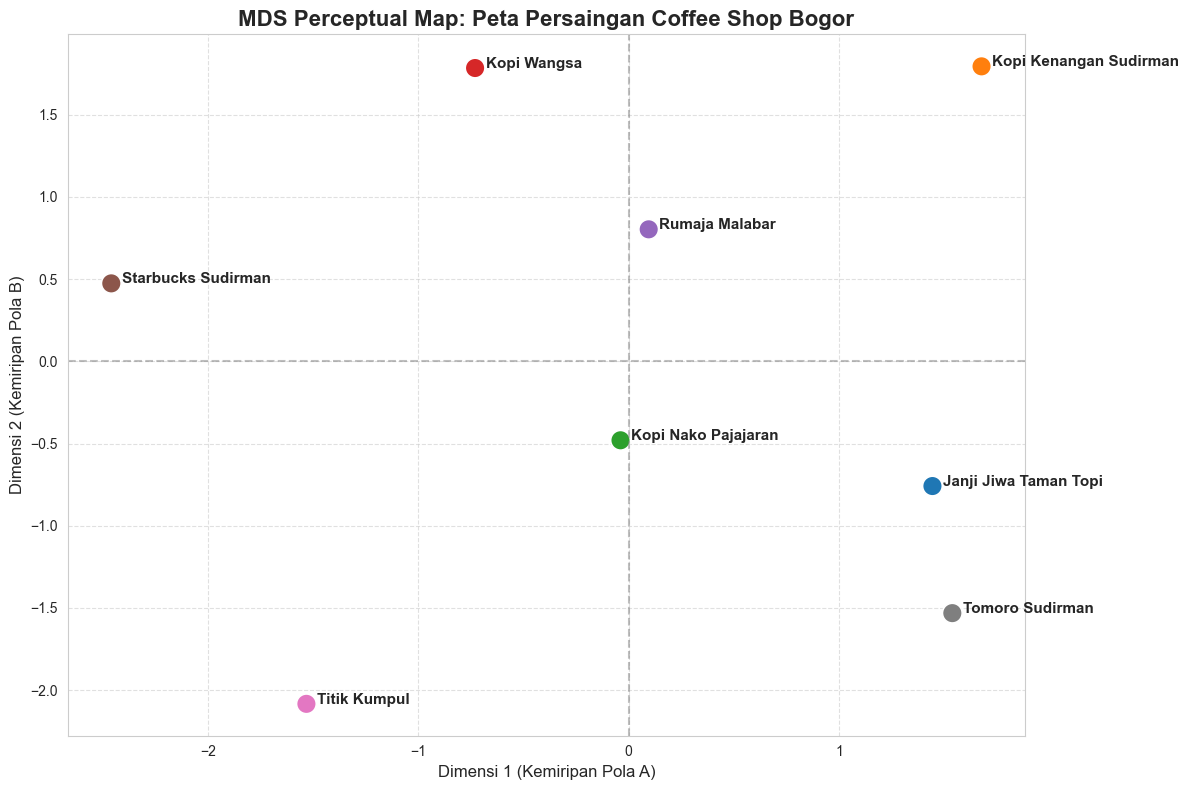

In [50]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Buat Scatter Plot
sns.scatterplot(data=df, x='X_MDS', y='Y_MDS', hue='Brand', s=200, palette='tab10', legend=False)

# Tambahkan Label Nama Brand di setiap titik
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.05, point['y'], str(point['val']), fontsize=11, weight='bold')

label_point(df['X_MDS'], df['Y_MDS'], df['Brand'], plt.gca())

# Tambahkan Garis Kuadran (Tengah)
plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5)

# Pemanis Grafik
plt.title('MDS Perceptual Map: Peta Persaingan Coffee Shop Bogor', fontsize=16, weight='bold')
plt.xlabel('Dimensi 1 (Kemiripan Pola A)', fontsize=12)
plt.ylabel('Dimensi 2 (Kemiripan Pola B)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Simpan dan Tampilkan
plt.tight_layout()
plt.savefig('Hasil_MDS_CoffeeShop.png', dpi=300)
plt.show()

In [9]:
print("\n=== JARAK KEMIRIPAN (DISTANCE MATRIX) ===")
# Menampilkan siapa paling mirip dengan siapa
dist_df = pd.DataFrame(dis_matrix, index=df['Brand'], columns=df['Brand'])
print(dist_df.iloc[:5, :5])


=== JARAK KEMIRIPAN (DISTANCE MATRIX) ===
Brand                   Janji Jiwa Taman Topi  Kopi Kenangan Sudirman  \
Brand                                                                   
Janji Jiwa Taman Topi                0.000000                3.774152   
Kopi Kenangan Sudirman               3.774152                0.000000   
Kopi Nako Pajajaran                  2.376277                4.857202   
Kopi Wangsa                          4.280324                5.149604   
Rumaja Malabar                       2.603132                3.316056   

Brand                   Kopi Nako Pajajaran  Kopi Wangsa  Rumaja Malabar  
Brand                                                                     
Janji Jiwa Taman Topi              2.376277     4.280324        2.603132  
Kopi Kenangan Sudirman             4.857202     5.149604        3.316056  
Kopi Nako Pajajaran                0.000000     2.334339        1.952964  
Kopi Wangsa                        2.334339     0.000000        2.2526

# Interpretasi

## Interpretasi Dimensi
Jika kita lihat data tabel, Starbucks, Titik Kumpul, dan Kopi Wangsa memiliki harga tertinggi dan mereka berada di Kiri Ekstrem pada peta. Sebaliknya, Tomoro, Kopi Kenangan, dan Janji Jiwa yang memiliki harga cukup terjangkau berada di Kanan Ekstrem.

Perhatikan jika semakin ke bawah, fasilitas kerja semakin lengkap. Titik Kumpul berada di paling bawah (Skor WFC 5.0). Ini adalah tempat tujuan (destination) untuk berlama-lama. Sedangkan semakin ke atas, cafe semakin tidak didesain untuk kerja (misalnya colokan minim/meja kecil).

Dimensi 1 (Sumbu X) : Tingkat Harga (Price Tier), Dimensi 2 (Sumbu Y) : Dukungan Fasilitas Kerja (WFC Intensity)

Kesimpulan: Semakin ke Kiri, semakin Premium/Mahal. Semakin ke Kanan, semakin Ekonomis/Terjangkau. Serta semakin ke Bawah, semakin Experience Oriented (Nyaman, WFC, Nongkrong). Semakin ke Atas, semakin Functional/Transactional (Cepat, Praktis, Minim Fasilitas).


## Insight
1. Productivity Haven : Titik kumpul. Mereka menangkap pasar freelancer atau mahasiswa berduit yang butuh tempat kerja serius, bukan sekadar ngopi. Pesaingnya bukan Starbucks (yang posisinya lebih ke tengah), tapi Coworking Space.

2. Budget Disruptor: Tomoro Coffee. Tomoro sedang mendisrupsi pasar dengan menawarkan Kualitas Rasa & Suasana Bintang 5

3. Status & Pure Coffee : Wangsa & Starbucks. Tujuan pengunjung bukan untuk kerja berjam-jam. Mereka datang untuk "Experience Rasa" (Wangsa: Skor Rasa 4.91) atau "Prestise Brand" (Starbucks). Mereka menjual kenikmatan, bukan fasilitas meja kerja.

4. Fast Transactional: Kopi Kenangan. Ini memvalidasi model bisnis mereka: Cepat, Murah, Pergi. Jangan harap nyaman nugas di sini (Skor Suasana 1.54, WFC 1.0). Mereka adalah raja di segmen Grab-and-Go.

## Kesimpulan Besar
Berdasarkan analisis Multidimensionality Scaling. Dapat disimpulkan bahwa peta persaingan Coffee Shop di Bogor tidak lagi sekadar perang harga (Murah vs Mahal), melainkan telah berevolusi menjadi perang fungsi ruang (Tempat Kerja vs Tempat Singgah).

Starbucks tidak lagi menjadi 'raja tunggal'; posisinya kini terhimpit oleh Titik Kumpul yang menawarkan fasilitas kerja lebih baik, dan Kopi Wangsa yang menawarkan spesialisasi rasa lebih tinggi. Sementara di level bawah, Tomoro Coffee muncul sebagai 'Market Disruptor' yang merusak batas antara segmen budget dan premium dengan memberikan kualitas tinggi di harga rendah.

## Saran
Penelitian ini memiliki keterbatasan yang dapat disempurnakan pada studi masa depan:

Validasi Data Primer: Penelitian ini sepenuhnya mengandalkan data sekunder (User Generated Content) dari Google Maps. Disarankan bagi peneliti selanjutnya untuk mengombinasikan metode ini dengan survei primer (kuesioner) kepada responden langsung untuk memvalidasi apakah persepsi yang tertulis di ulasan daring konsisten dengan preferensi nyata di lapangan.

Perluasan Variabel Atribut: Analisis ini berfokus pada Harga, Rasa, Suasana, dan WFC. Penambahan variabel lain yang relevan di Bogor, seperti Ketersediaan Lahan Parkir (mengingat kemacetan Bogor) dan Kecepatan Wi-Fi (diukur secara teknis, bukan persepsi), akan menghasilkan peta kompetisi yang lebih presisi.

Metode Analisis Sentimen: Meskipun telah menggunakan stemming dan penanganan slang, analisis sentimen berbasis aturan (rule-based) masih memiliki kelemahan dalam mendeteksi sarkasme atau ulasan implisit. Penggunaan algoritma Machine Learning (seperti Naive Bayes atau LSTM) atau Large Language Models (LLM) disarankan untuk meningkatkan akurasi ekstraksi opini konsumen.